<a href="https://colab.research.google.com/github/fabriziobasso/Closet_Index_Tracking/blob/master/rain_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **S4E10 - Rain Forecast**

The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

## Intro: Problem Statement

<div class="container">
        <p class="mb-2">
            Analyze weather data over a 5-day period to identify patterns and correlations between various meteorological factors such as pressure, temperature, humidity, and rainfall. This can help in understanding how these variables influence daily weather conditions.
        </p>
        <h1 class="mb-2">Dataset Description</h1>
        <p class="mb-2">The dataset captures weather data over five days with the following features:</p>
        <ul class="mb-2">
            <li class="mb-2"><strong>day:</strong> Sequential day number.</li>
            <li class="mb-2"><strong>pressure (hPa):</strong> Atmospheric pressure measured in hectopascals.</li>
            <li class="mb-2"><strong>maxtemp (°C):</strong> Maximum temperature recorded on the day.</li>
            <li class="mb-2"><strong>temperature (°C):</strong> Average temperature of the day.</li>
            <li class="mb-2"><strong>mintemp (°C):</strong> Minimum temperature recorded on the day.</li>
            <li class="mb-2"><strong>dewpoint (°C):</strong> Temperature at which air becomes saturated with moisture.</li>
            <li class="mb-2"><strong>humidity (%):</strong> Relative humidity percentage.</li>
            <li class="mb-2"><strong>cloud (%):</strong> Cloud cover percentage.</li>
            <li class="mb-2"><strong>rainfall:</strong> Indicates if rainfall occurred ("yes"/"no").</li>
            <li class="mb-2"><strong>sunshine (hours):</strong> Total sunshine hours.</li>
            <li class="mb-2"><strong>winddirection (°):</strong> Direction of the wind in degrees.</li>
            <li class="mb-2"><strong>windspeed (km/h):</strong> Speed of the wind.</li>
        </ul>
        <p class="mb-2">
            This dataset is ideal for basic weather pattern analysis and visualization.
        </p>
    </div>

## 1.0 Libraries

In [1]:
%%capture
#!pip install -qq pytorch_tabnet
!pip install optuna
!pip install catboost
#!pip install optuna-integration-pytorch-tabnet

#from pytorch_tabnet.tab_model import TabNetRegressor

!pip install --upgrade category-encoders
!pip install optuna-integration
!pip install colorama
#!pip install pyfiglet
!pip install keras-tuner --upgrade
!pip install keras-nlp
!pip install BorutaShap
!pip install --upgrade scikit-learn
!pip install scikit-lego
!pip install skops

#from pytorch_tabnet.tab_model import TabNetRegressor

In [2]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import numpy as np
from pickle import load, dump
import json
import joblib
import skops.io as sio
#import calplot as cal

# Graphic Libraries:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# Set Style
sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5});
sns.despine(left=True, bottom=True, top=False, right=False);
mpl.rcParams['figure.dpi'] = 120;
mpl.rc('axes', labelsize=12);
plt.rc('xtick',labelsize=10);
plt.rc('ytick',labelsize=10);

mpl.rcParams['axes.spines.top'] = False;
mpl.rcParams['axes.spines.right'] = False;
mpl.rcParams['axes.spines.left'] = True;

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

# tool for Excel:
from openpyxl import load_workbook, Workbook
from openpyxl.drawing.image import Image
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.worksheet.cell_range import CellRange

from openpyxl.formatting import Rule
from openpyxl.styles import Font, PatternFill, Border
from openpyxl.styles.differential import DifferentialStyle

# Bloomberg
#from xbbg import blp
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from xgboost.callback import EarlyStopping

import lightgbm as lgb
from lightgbm import (LGBMRegressor,
                      LGBMClassifier,
                      early_stopping,
                      record_evaluation,
                      log_evaluation)

# Time Management
from tqdm import tqdm
from datetime import date
from datetime import datetime
from pandas.tseries.offsets import BMonthEnd, QuarterEnd
from pandas.tseries.offsets import BDay # BDay is business day, not birthday...
import datetime as dt
import click
import glob
import os
import gc
import re
import string

from ipywidgets import AppLayout
from ipywidgets import Dropdown, Layout, HTML, AppLayout, VBox, Label, HBox, BoundedFloatText, interact, Output

#from my_func import *

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Reshape
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

from keras.utils import FeatureSpace, plot_model

# Import libraries for Hypertuning
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, GridSearch, BayesianOptimization

#from my_func import *

# preprocessing modules
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, cross_val_score, cross_validate, GroupKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   QuantileTransformer,
                                   PolynomialFeatures)

# metrics
import sklearn
#import skops.io as sio
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error,
                             root_mean_squared_log_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             multilabel_confusion_matrix,
                             accuracy_score,
                             roc_auc_score,
                             auc,
                             roc_curve,
                             log_loss,
                             make_scorer)
# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV,
                                  ElasticNet,
                                  BayesianRidge,
                                  HuberRegressor,
                                  TweedieRegressor,
                                  QuantileRegressor,
                                  ARDRegression,
                                  TheilSenRegressor,
                                  PoissonRegressor,
                                  GammaRegressor)

from sklearn.ensemble import (AdaBoostRegressor,
                              AdaBoostClassifier,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              VotingRegressor,
                              GradientBoostingRegressor,
                              GradientBoostingClassifier,
                              StackingRegressor,
                              StackingClassifier,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              ExtraTreesClassifier)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

import itertools
import warnings
from openpyxl import load_workbook

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.wrapper import PolynomialWrapper
from category_encoders.count import CountEncoder
from category_encoders import TargetEncoder

warnings.filterwarnings('ignore')
#import pyfiglet
#plt.style.use('fivethirtyeight')

<Figure size 640x480 with 0 Axes>

In [3]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.5,
         'grid.alpha'           :0.5,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
#         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
# Set Style
mpl.rcParams['figure.dpi'] = 120;

# import font colors
from colorama import Fore, Style, init

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

init(autoreset=True)

<Figure size 960x660 with 0 Axes>

In [4]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.0 Loading and Preprocessing Data


In [117]:
df_subm = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/sample_submission.csv", index_col=0)

validation = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_old.csv")
train = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_new.csv")
test = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test_enc.csv")

In [6]:
#df_train_old.isna().sum()

In [7]:
train.shape, test.shape, validation.shape

((2190, 23), (730, 22), (365, 23))

In [8]:
df_all_new = pd.concat([train, test], axis=0)
print(df_all_new.shape)
df_all_new.head(3)

(2920, 23)


,pressure,temparature,dewpoint,humidity,cloud,sunshine,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos,temp_diff,dewpoint_spread,range_dist_cloud,cloud_Humidity_Interaction,rainfall
0,0.654955,-0.629297,-0.183091,0.638922,0.692700,-0.745242,0.266192,0.404027,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.103102,0.994671,0.137279,0.990532,-1.885535,-1.201297,-1.147765,0.202762,1.0
1,1.019030,-1.329863,-0.924418,1.616306,0.853347,-1.044309,0.627866,0.523115,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.205104,0.978740,0.271958,0.962309,-2.468657,-1.047000,-1.714207,1.785597,1.0
2,1.816533,-1.481337,-2.054941,-0.827153,-1.502805,1.212287,0.107086,0.537809,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.304921,0.952378,0.401488,0.915864,0.382156,1.678918,-1.102818,-1.006968,1.0


In [9]:
df_all_new.tail(3)

,pressure,temparature,dewpoint,humidity,cloud,sunshine,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos,temp_diff,dewpoint_spread,range_dist_cloud,cloud_Humidity_Interaction,rainfall
727,1.573820,-1.026915,-0.905885,1.249787,1.121091,-1.044309,0.627866,0.523115,-3.442161e-02,0.999407,-6.880243e-02,0.997630,-1.031017e-01,0.994671,-2.051045e-01,0.978740,-2.719582e-01,0.962309,-0.136173,-0.275514,1.099351,1.826335,NaN
728,0.134842,-0.742902,-0.108959,1.494133,0.960444,-1.044309,1.374918,1.376817,-1.721336e-02,0.999852,-3.442161e-02,0.999407,-5.161967e-02,0.998667,-1.031017e-01,0.994671,-1.372788e-01,0.990532,-1.885537,-1.715621,-1.049108,1.789645,NaN
729,1.261754,-0.970113,-1.313614,-0.338461,0.746249,-0.989933,1.368967,2.235567,-2.449294e-16,1.000000,-4.898587e-16,1.000000,-7.347881e-16,1.000000,-1.469576e-15,1.000000,-1.959435e-15,1.000000,0.641322,1.010296,1.462053,1.115856,NaN


In [10]:
step = 1

past = 7
future = 0
learning_rate = 0.01
batch_size = 128
epochs = 21

test_final = df_all_new.iloc[2190-past+1:,:]

,pressure,temparature,dewpoint,humidity,cloud,sunshine,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos,temp_diff,dewpoint_spread,range_dist_cloud,cloud_Humidity_Interaction,rainfall
2184,0.377555,-0.970113,-0.498155,-0.460634,0.692700,-1.044309,1.597090,0.123532,-8.596480e-02,0.996298,-1.712931e-01,0.985220,-2.553533e-01,0.966848,-4.937756e-01,0.869589,-6.354323e-01,0.772157,-0.589712,-1.252730,0.151021,1.750204,1.0
2185,0.169507,-0.629297,-0.090425,1.860652,0.692700,-1.017121,0.816231,0.360335,-6.880243e-02,0.997630,-1.372788e-01,0.990532,-2.051045e-01,0.978740,-4.014880e-01,0.915864,-5.234156e-01,0.852078,-0.071382,-1.458459,0.670537,1.344175,1.0
2186,-0.211901,-1.254126,-0.942951,1.127614,0.692700,-1.044309,1.196644,1.173092,-5.161967e-02,0.998667,-1.031017e-01,0.994671,-1.543088e-01,0.988023,-3.049212e-01,0.952378,-4.014880e-01,0.915864,-2.144700,-0.789838,-1.407522,1.765692,1.0
2187,-0.055873,-1.443469,-1.443346,-0.338461,0.210760,0.315086,1.362553,0.799907,-3.442161e-02,0.999407,-6.880243e-02,0.997630,-1.031017e-01,0.994671,-2.051045e-01,0.978740,-2.719582e-01,0.962309,0.317365,0.084513,0.467794,-0.650790,1.0
2188,1.504467,-1.651745,-1.054150,1.249787,0.960444,-1.017121,0.608831,0.193460,-1.721336e-02,0.999852,-3.442161e-02,0.999407,-5.161967e-02,0.998667,-1.031017e-01,0.994671,-1.372788e-01,0.990532,-1.043251,-1.561324,-0.106237,1.373450,1.0
2189,0.030812,-0.913310,-0.442555,0.883268,0.692700,-0.772430,0.782381,2.316893,-2.449294e-16,1.000000,-4.898587e-16,1.000000,-7.347881e-16,1.000000,-1.469576e-15,1.000000,-1.959435e-15,1.000000,-0.654502,-1.252729,0.086083,0.257621,1.0
0,1.019030,-1.538140,-1.017084,1.738479,1.281738,-1.044309,0.729736,0.639529,1.721336e-02,0.999852,3.442161e-02,0.999407,5.161967e-02,0.998667,1.031017e-01,0.994671,1.372788e-01,0.990532,0.382157,-1.355594,1.953089,1.834583,NaN
1,0.498917,-1.405600,-0.980017,1.860652,1.281738,-1.044309,1.196644,1.173092,3.442161e-02,0.999407,6.880243e-02,0.997630,1.031017e-01,0.994671,2.051045e-01,0.978740,2.719582e-01,0.962309,-1.626371,-1.098432,-0.594767,1.838357,NaN
2,1.781868,-2.560588,-2.129074,0.516749,1.121091,-1.044309,0.553188,0.148689,5.161967e-02,0.998667,1.031017e-01,0.994671,1.543088e-01,0.988023,3.049212e-01,0.952378,4.014880e-01,0.915864,-1.561580,-1.047000,-0.600880,1.812801,NaN
3,1.608496,-1.254126,-2.017875,-0.827153,-1.609903,0.886032,2.838131,0.556665,6.880243e-02,0.997630,1.372788e-01,0.990532,2.051045e-01,0.978740,4.014880e-01,0.915864,5.234156e-01,0.852078,0.770904,2.193242,-1.074994,-0.960708,NaN


In [96]:
# Train data
x_train = train.iloc[:,:-1].values
y_train = train.iloc[past-1:,-1].values.reshape(-1,1)
print(x_train.shape, y_train.shape)
# Valid Data
x_valid = validation.iloc[:,:-1].values
y_valid = validation.iloc[past-1:,-1].values.reshape(-1,1)
print(x_valid.shape, y_valid.shape)
# Test Data
x_test = test_final.iloc[:,:-1].values
y_test = test_final.iloc[past-1:,-1].values.reshape(-1,1)
print(x_test.shape, y_test.shape)

(2190, 22) (2184, 1)
(365, 22) (359, 1)
(736, 22) (730, 1)


## 3.0 Dataset Management Functions

####  **3.1 Train Dataset**

In [97]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_train,
                                                                    y_train,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=10000,
                                                                    shuffle=True
                                                                 )


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (2184, 7, 22)
Target shape: (2184, 1)


In [98]:
# Find indices of 0s
indices_of_zeros = np.where(targets.numpy() == 0)[0]

# Find indices of 1s
indices_of_ones = np.where(targets.numpy() == 1)[0]

In [99]:
indices_of_zeros.shape,indices_of_ones.shape

((539,), (1645,))

* **TRAIN DATASET - INFINITE SAMPLING**

* **GOAL: Oversample the minority class**
A related approach would be to resample the dataset by oversampling the minority class.

In [100]:
pos_features = inputs.numpy()[indices_of_ones]
neg_features = inputs.numpy()[indices_of_zeros]

pos_labels = targets.numpy()[indices_of_ones]
neg_labels = targets.numpy()[indices_of_zeros]

pos_features.shape,pos_labels.shape,neg_features.shape,neg_labels.shape

((1645, 7, 22), (1645, 1), (539, 7, 22), (539, 1))

In [101]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [102]:
for num, (features, label) in enumerate(pos_ds.take(10)):
  #print("Features:\n", features.numpy())
  #print()
  print(f"Label sample {num}: ", label.numpy())

Label sample 0:  [1]
Label sample 1:  [1]
Label sample 2:  [1]
Label sample 3:  [1]
Label sample 4:  [1]
Label sample 5:  [1]
Label sample 6:  [1]
Label sample 7:  [1]
Label sample 8:  [1]
Label sample 9:  [1]


In [103]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(64).prefetch(2)

In [104]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.453125


#### **3.2 Validation Dataset**

In [105]:
dataset_validation = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_valid,
                                                                    y_valid,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=64,
                                                                    shuffle=False
                                                                 )


for batch in dataset_validation.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 7, 22)
Target shape: (64, 1)


#### **3.3 Test Dataset**

In [106]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_test,
                                                                    y_test,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=64,
                                                                    shuffle=False
                                                                 )


for batch in dataset_test.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 7, 22)
Target shape: (64, 1)


## 4.0 NN Models:

In [120]:
def plot_metrics(history):
  metrics = ['loss', 'auc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [107]:
step = 1

past = 7
future = 0
learning_rate = 0.01
batch_size = 64
epochs = 101

In [108]:
METRICS = [
          keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
          keras.metrics.AUC(name='auc'),
          keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

### 4.1 LSTM v0

In [109]:
def make_model(metrics=METRICS, units=[32,32], output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")
  data_noised = keras.layers.GaussianNoise(stddev=0.025, name="noise_layer")(data)
  lstm_out = keras.layers.LSTM(units[0], return_sequences=True, name="lstm_0")(data_noised)
  lstm_out = keras.layers.LSTM(units[1], name="lstm_1")(lstm_out)
  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(lstm_out)

  model = keras.Model(inputs=data, outputs=outputs, name="LSTM_v0")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model(units=[64,32])

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

Model: "LSTM_v0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 7, 22)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ noise_layer (GaussianNoise)          │ (None, 7, 22)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_0 (LSTM)                        │ (None, 7, 64)               │          22,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,721 (135.63 KB)

 Trainable params: 34,721 (135.63 KB)

 Non-trainable params: 0 (0.00 B)

#### Fit the model

In [110]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

1645 539


52

In [111]:
resampled_history = model.fit(
                              resampled_ds,
                              epochs=epochs,
                              steps_per_epoch=32,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5),
                                         keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")],
                              validation_data=dataset_validation
                              )

Epoch 1/101
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - auc: 0.6148 - cross entropy: 0.6732 - loss: 0.6732 - prc: 0.6127 - val_auc: 0.6862 - val_cross entropy: 0.6761 - val_loss: 0.6761 - val_prc: 0.8101 - learning_rate: 0.0010
Epoch 2/101
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - auc: 0.7111 - cross entropy: 0.6213 - loss: 0.6213 - prc: 0.7040 - val_auc: 0.7247 - val_cross entropy: 0.6683 - val_loss: 0.6683 - val_prc: 0.8285 - learning_rate: 0.0010
Epoch 3/101
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - auc: 0.7625 - cross entropy: 0.5889 - loss: 0.5889 - prc: 0.7452 - val_auc: 0.7797 - val_cross entropy: 0.6251 - val_loss: 0.6251 - val_prc: 0.8563 - learning_rate: 0.0010
Epoch 4/101
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - auc: 0.7994 - cross entropy: 0.5534 - loss: 0.5534 - prc: 0.7908 - val_auc: 0.8440 - val_cross entropy: 0.5118 - val_loss: 0.5118 - val_prc: 0.8905 - learning_rate: 0.0010
Epoch 5/101
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - auc: 0.8719 - cross entropy: 0.4638 - loss

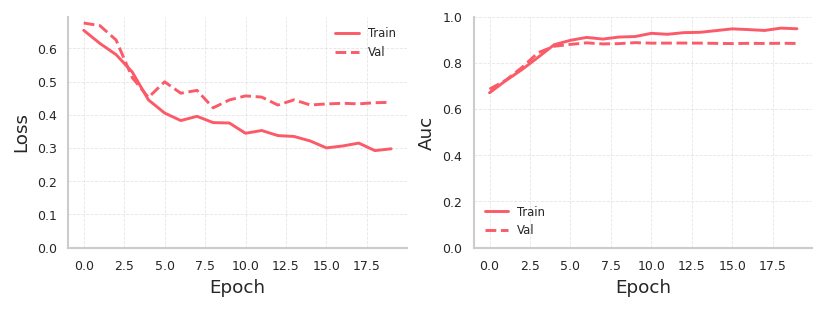

In [113]:
plot_metrics(resampled_history)

#### Evaluate Model:

In [114]:
train_predictions_resampled = model.predict(dataset_train)
valid_predictions_resampled = model.predict(dataset_validation)
test_predictions_resampled = model.predict(dataset_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


Legitimate Transactions Detected (True Negatives):  92
Legitimate Transactions Incorrectly Detected (False Positives):  24
Fraudulent Transactions Missed (False Negatives):  50
Fraudulent Transactions Detected (True Positives):  193
Total Fraudulent Transactions:  243


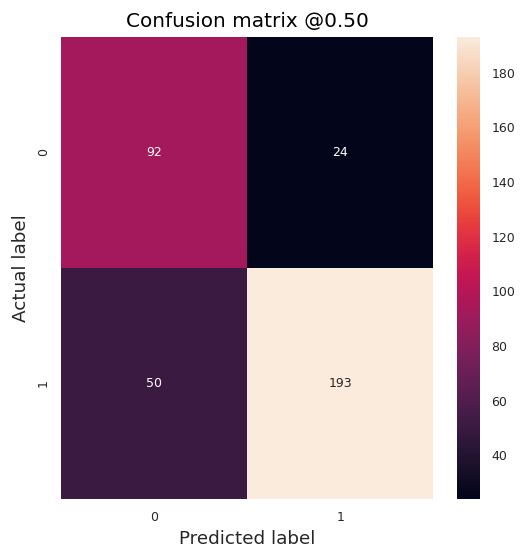

In [121]:
plot_cm(y_valid, valid_predictions_resampled)

In [123]:
df_subm["rainfall"] = test_predictions_resampled
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_v0.csv")

In [15]:
y_valid[:10]

array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1])

In [16]:
validation.head(10)

,pressure,temparature,dewpoint,humidity,cloud,sunshine,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos,temp_diff,dewpoint_spread,range_dist_cloud,cloud_Humidity_Interaction,rainfall
0,1.452458,-0.951179,-0.887351,-0.094115,0.424955,-0.881182,0.347721,0.202977,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.205104,0.978740,0.271958,0.962309,0.187783,-0.121217,0.607652,0.519015,1
1,1.053707,-0.875442,-0.368423,1.616306,0.853347,-1.044309,0.416607,0.038796,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.304921,0.952378,0.401488,0.915864,-1.237624,-1.355594,-0.394800,1.781525,1
2,0.915012,-0.629297,-0.294290,1.005441,0.692700,-0.772430,0.415635,0.280586,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.401488,0.915864,0.523416,0.852078,-0.654504,-0.892702,0.086081,0.262796,1
3,0.394898,-0.610362,-0.090425,1.616306,0.317858,-1.044309,0.391314,0.018445,0.085965,0.996298,0.171293,0.985220,0.255353,0.966848,0.493776,0.869589,0.635432,0.772157,-2.015120,-1.407026,-1.386769,1.709152,1
4,0.897668,-0.572494,-0.442555,0.272404,-1.288609,1.049159,0.598051,-0.225140,0.103102,0.994671,0.205104,0.978740,0.304921,0.952378,0.580800,0.814046,0.735417,0.677615,0.576529,-0.326946,-0.879598,-0.976980,1
5,1.417782,-0.970113,-0.998551,-0.338461,-1.020865,-0.119920,0.927827,0.141527,0.120208,0.992749,0.238673,0.971100,0.353676,0.935368,0.661635,0.749826,0.821477,0.570242,0.122992,0.135945,-0.834876,-0.610788,0
6,1.244411,-1.045850,-1.109750,-0.460634,-2.520234,1.049159,0.170442,0.245001,0.137279,0.990532,0.271958,0.962309,0.401488,0.915864,0.735417,0.677615,0.891981,0.452072,0.187783,0.238811,-1.696128,-1.112336,0
7,1.209734,-1.102652,-1.128283,-0.460634,0.210760,-0.147108,0.585890,1.799233,0.154309,0.988023,0.304921,0.952378,0.448229,0.893919,0.801361,0.598181,0.945596,0.325342,-1.561580,0.135946,-1.049938,-0.447891,0
8,0.672288,-1.121587,-0.905885,0.394577,0.853347,-1.044309,0.549754,1.704031,0.171293,0.985220,0.337523,0.941317,0.493776,0.869589,0.858764,0.512371,0.981306,0.192452,-1.885537,-0.532676,-1.089225,1.785597,1
9,0.498917,-1.102652,-0.739086,1.005441,0.799798,-0.473363,0.876934,0.409176,0.188227,0.982126,0.369725,0.929141,0.538005,0.842942,0.907014,0.421101,0.998435,0.055917,-0.200965,-0.944134,0.657086,-0.146131,1


In [17]:
train.head(10)

,pressure,temparature,dewpoint,humidity,cloud,sunshine,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos,temp_diff,dewpoint_spread,range_dist_cloud,cloud_Humidity_Interaction,rainfall
0,0.654955,-0.629297,-0.183091,0.638922,0.692700,-0.745242,0.266192,0.404027,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.103102,0.994671,0.137279,0.990532,-1.885535,-1.201297,-1.147765,0.202762,1
1,1.019030,-1.329863,-0.924418,1.616306,0.853347,-1.044309,0.627866,0.523115,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.205104,0.978740,0.271958,0.962309,-2.468657,-1.047000,-1.714207,1.785597,1
2,1.816533,-1.481337,-2.054941,-0.827153,-1.502805,1.212287,0.107086,0.537809,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.304921,0.952378,0.401488,0.915864,0.382156,1.678918,-1.102818,-1.006968,1
3,-0.038530,-1.159455,-0.664954,1.616306,1.067542,-1.044309,0.873709,1.413020,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.401488,0.915864,0.523416,0.852078,-1.950327,-1.304162,-1.083799,1.808886,1
4,1.417782,-1.045850,-1.999341,-3.637131,-1.609903,-0.065545,0.952812,0.470228,0.085965,0.996298,0.171293,0.985220,0.255353,0.966848,0.493776,0.869589,0.635432,0.772157,1.224442,2.707566,-0.956126,-0.701745,0
5,1.573820,-1.007981,-1.461880,-0.338461,0.317858,-1.044309,0.672513,-0.199152,0.103102,0.994671,0.205104,0.978740,0.304921,0.952378,0.580800,0.814046,0.735417,0.677615,-0.071382,1.318891,0.263802,1.736545,1
6,1.591153,-1.045850,-1.684278,-3.148439,-1.556354,1.021972,1.460575,0.075888,0.120208,0.992749,0.238673,0.971100,0.353676,0.935368,0.661635,0.749826,0.821477,0.570242,-0.006591,1.833215,-1.246718,-0.992682,0
7,1.053707,-1.954693,-1.591612,1.738479,1.335287,-1.044309,1.939451,2.021943,0.137279,0.990532,0.271958,0.962309,0.401488,0.915864,0.735417,0.677615,0.891981,0.452072,-0.719294,-0.892702,0.607610,1.846465,1
8,0.654955,-1.405600,-1.461880,0.516749,1.335287,-1.044309,1.290025,1.279805,0.154309,0.988023,0.304921,0.952378,0.448229,0.893919,0.801361,0.598181,0.945596,0.325342,-1.431998,0.238811,-0.314825,1.853866,1
9,2.041924,-1.803219,-2.184673,-0.582807,0.478504,-0.772430,1.323982,1.318610,0.171293,0.985220,0.337523,0.941317,0.493776,0.869589,0.858764,0.512371,0.981306,0.192452,0.187783,1.164594,0.670671,0.254367,0
